<a href="https://colab.research.google.com/github/taliarosenkranz/TranSecure/blob/main/Fraud_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
df = pd.read_excel("orders.xlsx")

Preprocessing

In [4]:
df.head()

,order_id,order_date,order_status,price,avs_mismatch,customer_account_age,order_source,billing_zip,shipping_name_length,classification_score,customer_id
0,621481,2023-06-11T00:00:00Z,approved,540,True,287,phone,41123,19,0.371480,372
1,788013,2022-10-30T00:00:00Z,approved,680,True,81,phone,71879,6,0.867578,860
2,743724,2023-06-19T00:00:00Z,chargeback,260,False,286,web,65701,20,0.630769,971
3,709340,2021-02-28T00:00:00Z,approved,720,False,320,mobile app,63666,18,0.431331,913
4,816507,2021-05-13T00:00:00Z,approved,990,True,31,phone,86613,8,0.276696,905


In [5]:
df.isnull().sum()

order_id                0
order_date              0
order_status            0
price                   0
avs_mismatch            0
customer_account_age    0
order_source            0
billing_zip             0
shipping_name_length    0
classification_score    0
customer_id             0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40825 entries, 0 to 40824
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   order_id              40825 non-null  int64  
 1   order_date            40825 non-null  object 
 2   order_status          40825 non-null  object 
 3   price                 40825 non-null  int64  
 4   avs_mismatch          40825 non-null  bool   
 5   customer_account_age  40825 non-null  int64  
 6   order_source          40825 non-null  object 
 7   billing_zip           40825 non-null  int64  
 8   shipping_name_length  40825 non-null  int64  
 9   classification_score  40825 non-null  float64
 10  customer_id           40825 non-null  int64  
dtypes: bool(1), float64(1), int64(6), object(3)
memory usage: 3.2+ MB


The dataset contains a score which classifies each transaction as more or less likely to be charged back. In order to label the dataset properly, a threshold will be set on the classification score and based on that, each transaction will be labeled as accepted or declined. With these labels, a machine learning model will be trained to predict weheather or not a transaction should be accepted or declined. With such a prediction, the company will be able to limit the chargeback amounts they are paying to their clients.



In [7]:
# calculating 90th percentile of score
threshold = np.percentile(df.classification_score, 90)
print(threshold)

0.9520177251845594


In [8]:
print(f'Based on the data provided, 90% of the orders will be approved if the classification score is at {round(threshold, 3)} or below. Any order with a score above this threshold will be understood as fraud and therefore declined.')

Based on the data provided, 90% of the orders will be approved if the classification score is at 0.952 or below. Any order with a score above this threshold will be understood as fraud and therefore declined.


In [9]:
#adding status of approval column based on threshold to df
df['status'] = df['classification_score'].apply(lambda x: 'Declined' if x > threshold else 'Approved')

In [10]:
distribution = df.status.value_counts()
distribution

status
Approved    36742
Declined     4083
Name: count, dtype: int64

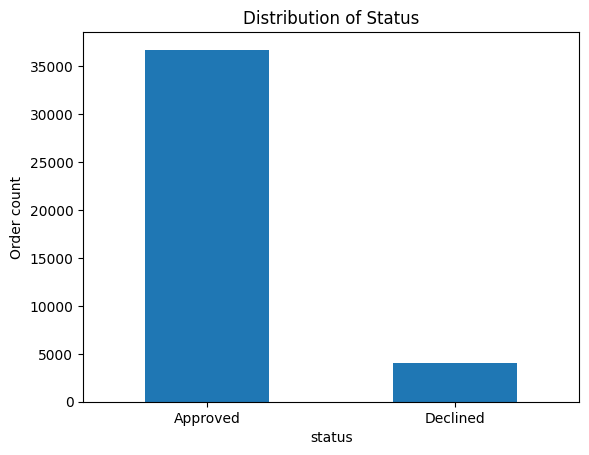

In [13]:
#visualizing the distribution between approved and denied orders based on set threshold
distribution.plot(kind = "bar")
plt.title("Distribution of Status")
plt.ylabel("Order count")
plt.xticks(rotation=0)
plt.show()

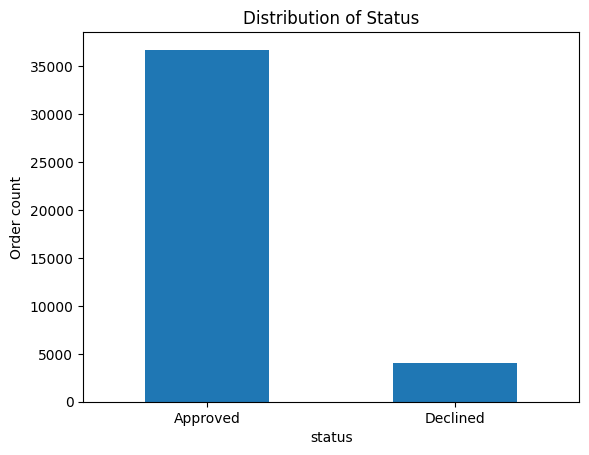

In [14]:
#visualizing the distribution between approved and denied orders based on set threshold
distribution.plot(kind = "bar")
plt.title("Distribution of Status")
plt.ylabel("Order count")
plt.xticks(rotation=0)
plt.show()

Plotting model score distribution

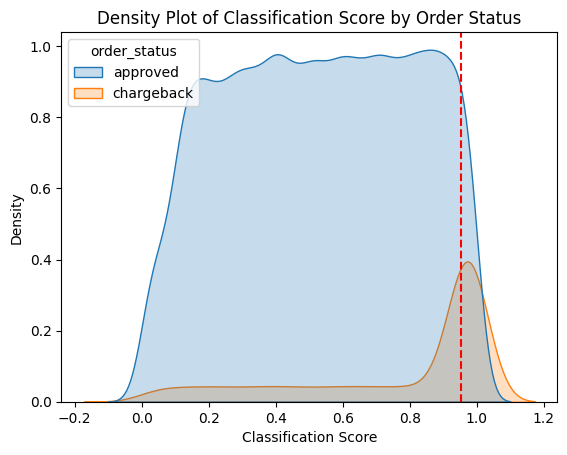

In [17]:
#density plot of classification score showing chargeback
sns.kdeplot(data=df, x="classification_score", hue="order_status", fill=True)
plt.title('Density Plot of Classification Score by Order Status')
plt.xlabel('Classification Score')
plt.ylabel('Density')
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold at 0.95')
plt.show()

 Machine Learning